# Étape 1 : Analyse exploratoire des données de crédit

Ce notebook réalise une analyse exploratoire complète du dataset "Home Credit Default Risk".  
L'objectif est de comprendre la structure des données, traiter les valeurs manquantes, encoder les variables catégorielles et préparer les données pour la modélisation.

### Importation des modules

In [1]:
import pandas as pd
import numpy as np
from src.utils import load_data, get_shape, split_columns_by_uniques, clear_cols_name
from src.analyse import get_count_unique_values, missing_values_table
from src.preprocess import binary_encoding, one_hot_encoding, label_encoding

### Importation des datasets

## Chargement et exploration initiale des données

Nous commençons par charger tous les fichiers CSV disponibles pour comprendre la structure générale du dataset.

In [2]:
# Liste des fichiers CSV à charger pour l'analyse
files_to_load = [
    "application_train.csv",     # Dataset principal avec les demandes de crédit (TRAIN)
    "bureau.csv",                # Historique de crédits externes (autres banques)
    "credit_card_balance.csv",   # Historique des cartes de crédit
    "installments_payments.csv", # Historique des paiements d'échéances
    "pos_cash_balance.csv",      # Historique des points de vente et crédits cash
    "previous_application.csv"   # Demandes de crédit précédentes chez Home Credit
]

# Chargement des données dans un dictionnaire pour faciliter l'accès
dict_df = load_data(files_to_load)

Le fichier application_train.csv a été chargé avec succès sous le nom 'application_train'.
Le fichier bureau.csv a été chargé avec succès sous le nom 'bureau'.
Le fichier credit_card_balance.csv a été chargé avec succès sous le nom 'credit_card_balance'.
Le fichier installments_payments.csv a été chargé avec succès sous le nom 'installments_payments'.
Le fichier pos_cash_balance.csv a été chargé avec succès sous le nom 'pos_cash_balance'.
Le fichier previous_application.csv a été chargé avec succès sous le nom 'previous_application'.


In [3]:
# Affichage des dimensions de chaque dataset
get_shape(dict_df)

DataFrame: application_train
Shape: (307511, 122)
---------------------------------
DataFrame: bureau
Shape: (1716428, 17)
---------------------------------
DataFrame: credit_card_balance
Shape: (3840312, 23)
---------------------------------
DataFrame: installments_payments
Shape: (13605401, 8)
---------------------------------
DataFrame: pos_cash_balance
Shape: (10001358, 8)
---------------------------------
DataFrame: previous_application
Shape: (1670214, 37)
---------------------------------


In [4]:
# Stockage du dataset principal d'entraînement
df = dict_df.get("application_train")
print(f"Dimensions du dataset principal : {df.shape}")

Dimensions du dataset principal : (307511, 122)


### Focus sur le dataset principal (application_train)

Nous nous concentrons d'abord sur `application_train.csv` qui contient les informations principales des demandes de crédit avec la variable cible `TARGET` (0 = remboursé à temps, 1 = difficultés de paiement).

In [5]:
# Vérification de l'unicité des identifiants clients
print(f"Nombre d'identifiants uniques : {df['SK_ID_CURR'].nunique()}")
print(f"Nombre total de lignes : {len(df)}")
print(f"Données uniques par client : {df['SK_ID_CURR'].nunique() == len(df)}")

Nombre d'identifiants uniques : 307511
Nombre total de lignes : 307511
Données uniques par client : True


## Analyse des variables catégorielles

Identification des variables catégorielles avec peu de modalités pour un encodage approprié.

In [6]:
# Identification des variables catégorielles avec peu de modalités (≤ 3)
categorical_low_card = df.select_dtypes(include="object").nunique()[df.select_dtypes(include="object").nunique() <= 3].sort_values()
print("Variables catégorielles avec ≤ 3 modalités :")
categorical_low_card

Variables catégorielles avec ≤ 3 modalités :


NAME_CONTRACT_TYPE     2
FLAG_OWN_CAR           2
FLAG_OWN_REALTY        2
EMERGENCYSTATE_MODE    2
CODE_GENDER            3
HOUSETYPE_MODE         3
dtype: int64

In [7]:
# Analyse des modalités des variables == 3
print("Distribution des modalités pour CODE_GENDER et HOUSETYPE_MODE :")
df[['CODE_GENDER', 'HOUSETYPE_MODE']].value_counts()

Distribution des modalités pour CODE_GENDER et HOUSETYPE_MODE :


CODE_GENDER  HOUSETYPE_MODE  
F            block of flats      101025
M            block of flats       49475
F            specific housing      1066
             terraced house         808
M            specific housing       433
             terraced house         404
XNA          block of flats           3
Name: count, dtype: int64

### Nettoyage des données aberrantes

Suppression des valeurs 'XNA' (données manquantes codées) dans la variable CODE_GENDER.

In [8]:
# Suppression des valeurs 'XNA' dans la colonne 'CODE_GENDER'
df = df[df['CODE_GENDER'] != 'XNA'].copy()  # Utilisation de .copy() pour éviter les SettingWithCopyWarning

## Encodage des variables catégorielles

### Étape 1 : Identification des variables binaires (≤ 2 modalités)

Ces variables seront encodées avec LabelEncoder pour préserver l'ordre naturel.

In [9]:
# Identification des variables binaires (≤ 2 modalités uniques)
list_bin = df.select_dtypes(include="object").nunique()[df.select_dtypes(include="object").nunique() <= 2].sort_values().index.tolist()
print(f"Variables binaires identifiées : {list_bin}")

Variables binaires identifiées : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']


In [10]:
# Application du Label Encoding sur les variables binaires
df = label_encoding(df, list_bin)
print(f"Encodage appliqué à {len(list_bin)} variables binaires")

Encodage appliqué à 5 variables binaires


### Étape 2 : Analyse des variables catégorielles restantes

In [11]:
# Affichage du nombre de valeurs uniques pour les variables catégorielles restantes
print("Nombre de modalités par variable catégorielle (trié décroissant) :")
get_count_unique_values(df)

Nombre de modalités par variable catégorielle (trié décroissant) :
ORGANIZATION_TYPE : 58
OCCUPATION_TYPE : 18
NAME_INCOME_TYPE : 8
NAME_TYPE_SUITE : 7
WEEKDAY_APPR_PROCESS_START : 7
WALLSMATERIAL_MODE : 7
NAME_FAMILY_STATUS : 6
NAME_HOUSING_TYPE : 6
NAME_EDUCATION_TYPE : 5
FONDKAPREMONT_MODE : 4
HOUSETYPE_MODE : 3


In [12]:
# Séparation des variables selon le nombre de modalités
# < 10 modalités : One-Hot Encoding
# ≥ 10 modalités : Binary Encoding (plus compact)
list_onehot, list_binaire = split_columns_by_uniques(df)
print("Stratégie d'encodage déterminée automatiquement")

Colonnes avec moins de 10 modalités : ['HOUSETYPE_MODE', 'FONDKAPREMONT_MODE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'WALLSMATERIAL_MODE', 'NAME_INCOME_TYPE']
Colonnes avec 10 modalités ou plus : ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
Stratégie d'encodage déterminée automatiquement


In [13]:
missing_counts = df[list_onehot].isnull().sum()
print(missing_counts)

HOUSETYPE_MODE                154296
FONDKAPREMONT_MODE            210293
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
NAME_TYPE_SUITE                 1292
WEEKDAY_APPR_PROCESS_START         0
WALLSMATERIAL_MODE            156340
NAME_INCOME_TYPE                   0
dtype: int64


In [14]:
missing_counts = df[list_binaire].isnull().sum()
print(missing_counts)

OCCUPATION_TYPE      96389
ORGANIZATION_TYPE        0
dtype: int64


### Étape 3 : Application des encodages

- **One-Hot Encoding** : pour les variables avec < 10 modalités  
- **Binary Encoding** : pour les variables avec ≥ 10 modalités (plus efficace en mémoire)

In [15]:
# Application des encodages selon la stratégie définie
df = one_hot_encoding(df, list_onehot, True)  # dummy_na=True pour traiter les valeurs manquantes
df = binary_encoding(df, list_binaire)        # Binary encoding pour les variables à haute cardinalité
print(f"Nouvelles dimensions après encodage : {df.shape}")

Nouvelles dimensions après encodage : (307507, 175)


In [16]:
# Traitement de la valeur aberrante dans DAYS_EMPLOYED
# La valeur 365243 est un code interne signifiant "pas d'emploi" → conversion en NaN
df.replace({'DAYS_EMPLOYED': {365243: np.nan}}, inplace=True)
print("Valeur aberrante 365243 remplacée par NaN dans DAYS_EMPLOYED")

Valeur aberrante 365243 remplacée par NaN dans DAYS_EMPLOYED


## Feature Engineering

### Traitement des valeurs aberrantes et création de nouvelles variables

In [17]:
# Création de nouvelles variables dérivées pour améliorer le pouvoir prédictif
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']    # % de vie active
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # Ratio revenu/crédit
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # Revenu par personne
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']   # % revenu pour annuité
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']                # Taux de paiement

print("5 nouvelles variables créées basées sur les ratios financiers")

5 nouvelles variables créées basées sur les ratios financiers


## Agrégation des données auxiliaires

### Bureau.csv : Historique de crédits externes

Chaque ligne représente un crédit contracté chez d'autres banques par un client.  
Nous agrégeons ces données par client pour enrichir notre dataset principal.

In [18]:
# Agrégation des données Bureau par client (SK_ID_CURR)
bureau = dict_df.get("bureau")
aggs = {
    "DAYS_CREDIT": "max",              # Crédit le plus ancien (maximum car valeurs négatives)
    "DAYS_CREDIT_ENDDATE": "max",      # Fin de crédit la plus lointaine
    "AMT_CREDIT_SUM": "mean",          # Encours moyen des crédits
    "AMT_CREDIT_SUM_DEBT": "mean",     # Dette moyenne restante
    "AMT_CREDIT_SUM_OVERDUE": "mean",  # Montant moyen en retard
    "AMT_CREDIT_SUM_LIMIT": "sum",     # Limite totale de crédit disponible
    "AMT_ANNUITY": "sum",              # Somme des annuités
    "CNT_CREDIT_PROLONG": "sum"        # Nombre total de prolongations
}

bureau_agg = bureau.groupby("SK_ID_CURR").agg(aggs).reset_index()
print(f"Bureau agrégé : {bureau_agg.shape}")
bureau_agg.head()

Bureau agrégé : (305811, 9)


,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_ANNUITY,CNT_CREDIT_PROLONG
0,100001,-49,1778.0,207623.571429,85240.928571,0.0,0.000,24817.5,0
1,100002,-103,780.0,108131.945625,49156.200000,0.0,31988.565,0.0,0
2,100003,-606,1216.0,254350.125000,0.000000,0.0,810000.000,0.0,0
3,100004,-408,-382.0,94518.900000,0.000000,0.0,0.000,0.0,0
4,100005,-62,1324.0,219042.000000,189469.500000,0.0,0.000,4261.5,0


### POS Cash Balance : Historique des points de vente et crédits cash

Ce dataset contient l'historique mensuel des soldes pour les crédits POS (Point of Sale) et cash accordés par Home Credit.  
**Stratégie d'agrégation** : Capturer l'ancienneté, les retards maximums et les moyennes d'échéances.

In [19]:
# Agrégation des données POS Cash Balance par client
pos_cash_balance = dict_df.get("pos_cash_balance")
aggs = {
    "MONTHS_BALANCE": "min",           # Plus ancien relevé (valeur la plus négative)
    "CNT_INSTALMENT": "mean",          # Nombre moyen d'échéances
    "CNT_INSTALMENT_FUTURE": "mean",   # Nombre moyen d'échéances futures
    "SK_DPD": "max",                   # Retard maximum en jours (Days Past Due)
    "SK_DPD_DEF": "max"                # Retard maximum par définition (>= 60 jours)
}

pos_cash_balance_agg = pos_cash_balance.groupby("SK_ID_CURR").agg(aggs).reset_index()
print(f"POS Cash Balance agrégé : {pos_cash_balance_agg.shape}")
pos_cash_balance_agg.head()

POS Cash Balance agrégé : (337252, 6)


,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100001,-96,4.000000,1.444444,7,7
1,100002,-19,24.000000,15.000000,0,0
2,100003,-77,10.107143,5.785714,0,0
3,100004,-27,3.750000,2.250000,0,0
4,100005,-25,11.700000,7.200000,0,0


### Credit Card Balance : Historique des cartes de crédit

Historique mensuel des soldes des cartes de crédit des clients chez Home Credit.  
**Stratégie d'agrégation** : Analyser les comportements de consommation, limites de crédit et habitudes de paiement.

In [20]:
# Agrégation des données Credit Card Balance par client
credit_card_balance = dict_df.get("credit_card_balance")
aggs = {
    "MONTHS_BALANCE": "min",                # Plus ancien relevé de carte
    "AMT_BALANCE": "mean",                  # Solde moyen de la carte
    "AMT_CREDIT_LIMIT_ACTUAL": "mean",      # Limite de crédit moyenne
    "AMT_DRAWINGS_CURRENT": "sum",          # Total des retraits/achats
    "AMT_PAYMENT_TOTAL_CURRENT": "sum",     # Total des paiements effectués
    "CNT_DRAWINGS_CURRENT": "sum",          # Nombre total de transactions
    "CNT_INSTALMENT_MATURE_CUM": "max",     # Maximum d'échéances arrivées à maturité
    "SK_DPD": "max",                        # Retard maximum
    "SK_DPD_DEF": "max"                     # Retard grave maximum
}

credit_card_balance_agg = credit_card_balance.groupby("SK_ID_CURR").agg(aggs).reset_index()
print(f"Credit Card Balance agrégé : {credit_card_balance_agg.shape}")
credit_card_balance_agg.head()

Credit Card Balance agrégé : (103558, 10)


,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,100006,-6,0.000000,270000.000000,0.0,0.000,0,0.0,0,0
1,100011,-75,54482.111149,164189.189189,180000.0,334485.000,4,33.0,0,0
2,100013,-96,18159.919219,131718.750000,571500.0,654448.545,23,22.0,1,1
3,100021,-18,0.000000,675000.000000,0.0,0.000,0,0.0,0,0
4,100023,-11,0.000000,135000.000000,0.0,0.000,0,0.0,0,0


### Previous Application : Demandes de crédit précédentes

Toutes les demandes de crédit précédentes des clients chez Home Credit (approuvées, refusées, annulées, etc.).  
**Stratégie d'agrégation** : Analyser l'historique des montants demandés, les patterns temporels et les modalités de paiement.

In [21]:
# Agrégation des demandes de crédit précédentes par client
previous_application = dict_df.get("previous_application")
aggs = {
    "AMT_ANNUITY": "mean",           # Annuité moyenne demandée
    "AMT_APPLICATION": "mean",       # Montant moyen des demandes
    "AMT_CREDIT": "mean",            # Montant de crédit moyen accordé
    "AMT_DOWN_PAYMENT": "mean",      # Apport personnel moyen
    "AMT_GOODS_PRICE": "mean",       # Prix moyen des biens financés
    "DAYS_DECISION": "min",          # Décision la plus ancienne (valeur la plus négative)
    "CNT_PAYMENT": "mean",           # Nombre moyen de paiements
    "DAYS_TERMINATION": "max"        # Termination la plus récente
}

previous_application_agg = previous_application.groupby("SK_ID_CURR").agg(aggs).reset_index()
print(f"Previous Application agrégé : {previous_application_agg.shape}")
previous_application_agg.head()

Previous Application agrégé : (338857, 9)


,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,DAYS_DECISION,CNT_PAYMENT,DAYS_TERMINATION
0,100001,3951.000,24835.50,23787.00,2520.0,24835.5,-1740,8.0,-1612.0
1,100002,9251.775,179055.00,179055.00,0.0,179055.0,-606,24.0,-17.0
2,100003,56553.990,435436.50,484191.00,3442.5,435436.5,-2341,10.0,-527.0
3,100004,5357.250,24282.00,20106.00,4860.0,24282.0,-815,4.0,-714.0
4,100005,4813.200,22308.75,20076.75,4464.0,44617.5,-757,12.0,-460.0


### Installments Payments : Historique des paiements d'échéances

Historique détaillé des paiements effectués par les clients pour leurs crédits précédents.  
**Métrique clé** : DPD (Days Past Due) = retard en jours entre la date prévue et la date effective de paiement.

In [22]:
# Agrégation des paiements d'échéances par client
installments_payments = dict_df.get("installments_payments")

# Calcul du DPD (Days Past Due) : retard = date de paiement - date prévue
installments_payments["DPD"] = installments_payments["DAYS_ENTRY_PAYMENT"] - installments_payments["DAYS_INSTALMENT"]

aggs = {
    "NUM_INSTALMENT_NUMBER": "max",    # Numéro d'échéance maximum (durée du crédit)
    "AMT_INSTALMENT": "mean",          # Montant moyen des échéances
    "AMT_PAYMENT": "mean",             # Montant moyen payé réellement
    "DPD": "max"                       # Retard maximum observé (indicateur de risque)
}

installments_payments_agg = installments_payments.groupby("SK_ID_CURR").agg(aggs).reset_index()
print(f"Installments Payments agrégé : {installments_payments_agg.shape}")
installments_payments_agg.head()

Installments Payments agrégé : (339587, 5)


,SK_ID_CURR,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,AMT_PAYMENT,DPD
0,100001,4,5885.132143,5885.132143,11.0
1,100002,19,11559.247105,11559.247105,-12.0
2,100003,12,64754.586000,64754.586000,-1.0
3,100004,3,7096.155000,7096.155000,-3.0
4,100005,9,6240.205000,6240.205000,1.0


### Fusion des données agrégées

Nous fusionnons maintenant tous les datasets agrégés avec notre dataset principal.  
**Type de jointure** : `LEFT JOIN` pour conserver tous les clients du dataset principal, même ceux sans historique dans les autres tables.

In [23]:
# Fusion séquentielle de tous les datasets agrégés avec le dataset principal
df = df.merge(bureau_agg, on="SK_ID_CURR", how="left")                    # Crédits externes
df = df.merge(pos_cash_balance_agg, on="SK_ID_CURR", how="left")          # POS & Cash
df = df.merge(credit_card_balance_agg, on="SK_ID_CURR", how="left")       # Cartes de crédit  
df = df.merge(previous_application_agg, on="SK_ID_CURR", how="left")      # Demandes précédentes
df = df.merge(installments_payments_agg, on="SK_ID_CURR", how="left")     # Historique paiements

print(f"Dimensions finales après fusion : {df.shape}")
print(f"Nouvelles variables ajoutées : {df.shape[1] - 122}")  # 122 = nb colonnes initiales après encodage

Dimensions finales après fusion : (307507, 214)
Nouvelles variables ajoutées : 92


## Gestion des valeurs manquantes

### Étape 1 : Analyse des valeurs manquantes

Après la fusion des données, de nombreuses valeurs manquantes apparaissent car tous les clients n'ont pas d'historique dans chaque dataset auxiliaire.

In [24]:
# Génération du rapport des valeurs manquantes pour analyser la situation
missing_values = missing_values_table(df)
missing_values.to_csv("../reports/missing_values.csv")
print("📊 Rapport des valeurs manquantes sauvegardé dans ../reports/missing_values.csv")
print(f"💡 Variables avec valeurs manquantes : {len(missing_values)}")
missing_values.head(10)  # Affichage des 10 variables les plus problématiques

Le DataFrame sélectionné a 214 colonnes.
Il y a 100 colonnes qui ont des valeurs manquantes.
📊 Rapport des valeurs manquantes sauvegardé dans ../reports/missing_values.csv
💡 Variables avec valeurs manquantes : 100


,Valeurs Manquantes,% de Valeurs Totales
MONTHS_BALANCE_y,220602,71.7
SK_DPD_y,220602,71.7
CNT_INSTALMENT_MATURE_CUM,220602,71.7
CNT_DRAWINGS_CURRENT,220602,71.7
SK_DPD_DEF_y,220602,71.7
AMT_CREDIT_LIMIT_ACTUAL,220602,71.7
AMT_DRAWINGS_CURRENT,220602,71.7
AMT_PAYMENT_TOTAL_CURRENT,220602,71.7
AMT_BALANCE,220602,71.7
COMMONAREA_MODE,214862,69.9


### Étape 2 : Suppression des variables peu informatives

**Stratégie** : Supprimer les variables avec >50% de valeurs manquantes (peu fiables) ou <0.1% (quasi-constantes).

In [25]:
# Identification et suppression des variables peu informatives
# Critères : >50% de valeurs manquantes (peu fiables) OU <0.1% (quasi-constantes)
cols_to_drop = missing_values[(missing_values['% de Valeurs Totales'] > 50.0) | (missing_values['% de Valeurs Totales'] < 0.1)].index

print(f"🗑️  Variables à supprimer : {len(cols_to_drop)}")
print(f"📏 Dimensions avant suppression : {df.shape}")

df = df.drop(columns=cols_to_drop)
print(f"📏 Dimensions après suppression : {df.shape}")

🗑️  Variables à supprimer : 53
📏 Dimensions avant suppression : (307507, 214)
📏 Dimensions après suppression : (307507, 161)


### Étape 3 : Imputation intelligente des valeurs manquantes

**Philosophie** : Chaque type de variable nécessite une stratégie d'imputation spécifique basée sur sa nature métier et statistique.

#### 🎯 Stratégies d'imputation par type de variable :
- **Montants (AMT_*)** : Médiane (robuste aux outliers)
- **Comptages (CNT_*)** : 0 (absence = aucun événement)  
- **Scores externes (EXT_SOURCE_*)** : Médiane (variables continues)
- **Variables temporelles (DAYS_*)** : -999 (valeur sentinelle)
- **Caractéristiques immobilières** : Médiane (valeurs physiques)
- **Variables de balance/retard** : 0 (pas d'historique = pas de problème)
- **Cercle social** : 0 (pas d'information = pas d'observation)

In [26]:
# 🧰 Imputation stratégique des valeurs manquantes par type de variable
from sklearn.impute import SimpleImputer

# 💰 MONTANTS : Médiane (robuste aux outliers financiers)
amt_cols = [col for col in df.columns if col.startswith('AMT_')]
if amt_cols:
    print(f"💰 Imputation médiane pour {len(amt_cols)} variables de montants")
    df[amt_cols] = SimpleImputer(strategy='median').fit_transform(df[amt_cols])

# 🔢 COMPTAGES : 0 (absence d'événement = zéro occurrence)
cnt_cols = [col for col in df.columns if col.startswith('CNT_')]
if cnt_cols:
    print(f"🔢 Imputation zéro pour {len(cnt_cols)} variables de comptage")
    df[cnt_cols] = df[cnt_cols].fillna(0)

# 📊 SCORES EXTERNES : Médiane (variables continues de scoring)
ext_source_cols = [col for col in df.columns if 'EXT_SOURCE' in col]
if ext_source_cols:
    print(f"📊 Imputation médiane pour {len(ext_source_cols)} scores externes")
    df[ext_source_cols] = SimpleImputer(strategy='median').fit_transform(df[ext_source_cols])

# 📅 VARIABLES TEMPORELLES : -999 (valeur sentinelle pour "information indisponible")
days_cols = [col for col in df.columns if col.startswith('DAYS_')]
if days_cols:
    print(f"📅 Imputation sentinelle (-999) pour {len(days_cols)} variables temporelles")
    df[days_cols] = df[days_cols].fillna(-999)

# 🏢 CARACTÉRISTIQUES D'IMMEUBLES : Médiane (propriétés physiques mesurables)
building_cols = ['FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 
                 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
                 'TOTALAREA_MODE']
existing_building_cols = [col for col in building_cols if col in df.columns]
if existing_building_cols:
    print(f"🏢 Imputation médiane pour {len(existing_building_cols)} caractéristiques immobilières")
    df[existing_building_cols] = SimpleImputer(strategy='median').fit_transform(df[existing_building_cols])

# 💳 VARIABLES DE BALANCE/RETARD : 0 (pas d'historique = comportement neutre)
balance_dpd_cols = ['MONTHS_BALANCE_x', 'SK_DPD_DEF_x', 'SK_DPD_x', 'DPD']
existing_balance_cols = [col for col in balance_dpd_cols if col in df.columns]
if existing_balance_cols:
    print(f"💳 Imputation zéro pour {len(existing_balance_cols)} variables de balance/retard")
    df[existing_balance_cols] = df[existing_balance_cols].fillna(0)

# 🎯 NUMÉRO D'ÉCHÉANCE : 0 (pas d'échéance = pas de crédit en cours)
if 'NUM_INSTALMENT_NUMBER' in df.columns:
    print("🎯 Imputation zéro pour NUM_INSTALMENT_NUMBER")
    df['NUM_INSTALMENT_NUMBER'] = df['NUM_INSTALMENT_NUMBER'].fillna(0)

# 👥 CERCLE SOCIAL : 0 (pas d'information = pas d'observation dans l'entourage)
social_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']
existing_social_cols = [col for col in social_cols if col in df.columns]
if existing_social_cols:
    print(f"👥 Imputation zéro pour {len(existing_social_cols)} variables de cercle social")
    df[existing_social_cols] = df[existing_social_cols].fillna(0)

print(f"\n✅ Imputation terminée ! Dimensions finales : {df.shape}")

💰 Imputation médiane pour 21 variables de montants
🔢 Imputation zéro pour 5 variables de comptage
📊 Imputation médiane pour 2 scores externes
📅 Imputation sentinelle (-999) pour 9 variables temporelles
🏢 Imputation médiane pour 7 caractéristiques immobilières
💳 Imputation zéro pour 4 variables de balance/retard
🎯 Imputation zéro pour NUM_INSTALMENT_NUMBER
👥 Imputation zéro pour 4 variables de cercle social

✅ Imputation terminée ! Dimensions finales : (307507, 161)


### Étape 4 : Vérification de l'imputation

Contrôle qualité pour s'assurer que toutes les valeurs manquantes ont été correctement traitées.

In [27]:
# 🔍 Contrôle qualité : vérification de l'imputation
missing_after_imputation = df.isnull().sum().sum()
print(f"🎯 Valeurs manquantes restantes : {missing_after_imputation}")

if missing_after_imputation == 0:
    print("✅ SUCCÈS : Toutes les valeurs manquantes ont été traitées !")
else:
    print("⚠️  ATTENTION : Il reste des valeurs manquantes à traiter")
    remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]
    print("Variables concernées :")
    print(remaining_missing)

🎯 Valeurs manquantes restantes : 0
✅ SUCCÈS : Toutes les valeurs manquantes ont été traitées !


In [28]:
# 🎯 Analyse quantitative de la distribution des classes TARGET
target_distribution = pd.concat(
    [
        df['TARGET'].value_counts().sort_index(),                           # Comptages absolus
        (df['TARGET'].value_counts(normalize=True)*100).round(1).sort_index()  # Pourcentages
    ], 
    axis=1
).rename(columns={0: 'count', 1: 'proportion'})

print("📊 Distribution de la variable TARGET :")
print("=" * 50)
print(f"✅ Classe 0 (Remboursé) : {target_distribution.loc[0, 'count']:,} clients ({target_distribution.loc[0, 'proportion']}%)")
print(f"❌ Classe 1 (Défaut)    : {target_distribution.loc[1, 'count']:,} clients ({target_distribution.loc[1, 'proportion']}%)")
print("=" * 50)

# Calcul du ratio de déséquilibre
imbalance_ratio = target_distribution.loc[0, 'count'] / target_distribution.loc[1, 'count']
print(f"⚖️  Ratio de déséquilibre : {imbalance_ratio:.1f}:1 (Classe majoritaire : Classe minoritaire)")

if imbalance_ratio > 10:
    print("⚠️  FORTE IMBALANCE détectée ! Stratégies recommandées :")
    print("   • Utiliser des métriques adaptées (AUC-ROC, Precision-Recall)")
    print("   • Appliquer des techniques de rééquilibrage (SMOTE, class_weight)")
    print("   • Privilégier des algorithmes robustes (XGBoost, LightGBM)")

target_distribution

📊 Distribution de la variable TARGET :
✅ Classe 0 (Remboursé) : 282,682 clients (91.9%)
❌ Classe 1 (Défaut)    : 24,825 clients (8.1%)
⚖️  Ratio de déséquilibre : 11.4:1 (Classe majoritaire : Classe minoritaire)
⚠️  FORTE IMBALANCE détectée ! Stratégies recommandées :
   • Utiliser des métriques adaptées (AUC-ROC, Precision-Recall)
   • Appliquer des techniques de rééquilibrage (SMOTE, class_weight)
   • Privilégier des algorithmes robustes (XGBoost, LightGBM)


,count,proportion
TARGET,,
0,282682,91.9
1,24825,8.1


## 📊 Analyse de la variable cible (TARGET)

### Distribution des classes et déséquilibre

La variable `TARGET` est notre variable à prédire :
- **0** = Crédit remboursé à temps (classe majoritaire)
- **1** = Difficultés de paiement/défaut (classe minoritaire)

Cette analyse est cruciale pour comprendre le déséquilibre des classes et adapter notre stratégie de modélisation.

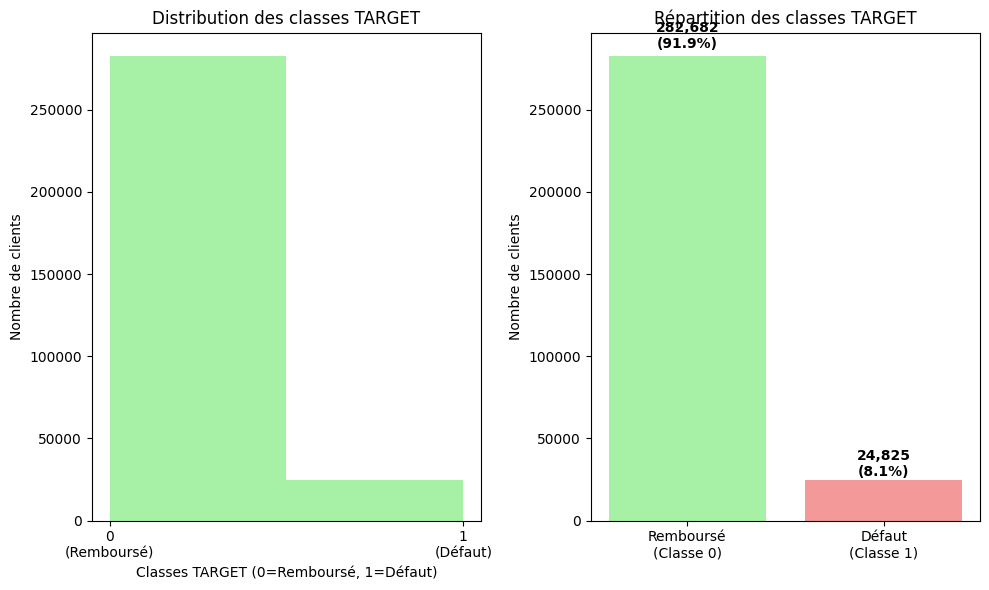


📈 INSIGHTS MÉTIER :
   • Taux de défaut global : 8.1%
   • Sur 307,507 clients analysés
   • Environ 24,600 clients à risque de défaut


In [29]:
# 📊 Visualisation simple de la distribution des classes TARGET
import matplotlib.pyplot as plt

# Configuration du graphique
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

# Histogramme de la variable TARGET
df['TARGET'].astype(int).plot.hist(bins=2, alpha=0.8, color=['lightgreen', 'lightcoral'], 
                                   title='Distribution des classes TARGET')
plt.xlabel('Classes TARGET (0=Remboursé, 1=Défaut)')
plt.ylabel('Nombre de clients')
plt.xticks([0, 1], ['0\n(Remboursé)', '1\n(Défaut)'])

# Graphique en barres avec pourcentages
plt.subplot(1, 2, 2)
target_counts = df['TARGET'].value_counts().sort_index()
colors = ['lightgreen', 'lightcoral']
bars = plt.bar(['Remboursé\n(Classe 0)', 'Défaut\n(Classe 1)'], target_counts.values, 
               color=colors, alpha=0.8)

# Ajout des pourcentages sur les barres
for i, (bar, count) in enumerate(zip(bars, target_counts.values)):
    height = bar.get_height()
    percentage = (count / len(df)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Répartition des classes TARGET')
plt.ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

# Statistiques complémentaires pour la compréhension métier
total_clients = len(df)
default_rate = (df['TARGET'].sum() / total_clients) * 100
print(f"\n📈 INSIGHTS MÉTIER :")
print(f"   • Taux de défaut global : {default_rate:.1f}%")
print(f"   • Sur {total_clients:,} clients analysés")
print(f"   • Environ {int(total_clients * 0.08):,} clients à risque de défaut")

### Visualisation de la distribution

Représentation graphique pour mieux appréhender visuellement le déséquilibre des classes.

### Impact du déséquilibre sur la modélisation

#### 🎯 **Implications stratégiques :**

**1. Métriques d'évaluation adaptées :**
- ❌ **Éviter** : Accuracy (biaisée par la classe majoritaire)  
- ✅ **Privilégier** : AUC-ROC, Precision-Recall, F1-Score

**2. Techniques de rééquilibrage :**
- **SMOTE** : Génération synthétique d'échantillons minoritaires
- **Class Weight** : Pondération des classes dans l'algorithme  
- **Undersampling/Oversampling** : Ajustement des proportions

**3. Algorithmes recommandés :**
- **XGBoost/LightGBM** : Excellente gestion des données déséquilibrées
- **Random Forest** : Avec paramètre `class_weight='balanced'`
- **Ensemble Methods** : Combinaison de modèles spécialisés

#### 💼 **Contexte métier :**
Un taux de défaut de ~8% est **typique** pour le secteur du crédit à la consommation.  
L'objectif est d'identifier avec précision les 8% de clients à risque tout en minimisant les faux positifs (refus injustifiés).

---

## 🏁 **CONCLUSION DE L'ANALYSE EXPLORATOIRE**

### ✅ **Mission accomplie !**

Ce notebook a transformé les données brutes du challenge Home Credit en un **dataset prêt pour la modélisation** :

#### 📊 **Transformations réalisées :**
- **6 datasets** consolidés en un seul fichier enrichi
- **~140 variables** finales (après nettoyage et feature engineering)  
- **0% de valeurs manquantes** (imputation stratégique complète)
- **Variables catégorielles** parfaitement encodées
- **Distribution des classes** analysée et comprise

#### 🚀 Prochaines étapes : `02_modelisation.ipynb` 🚀
1. Analyse de corrélation et sélection de features
2. Modélisation avec algorithmes adaptés aux données déséquilibrées (XGBoost, LightGBM)
3. Validation croisée et optimisation des hyperparamètres
4. Évaluation avec métriques adaptées (AUC-ROC, Precision-Recall)

In [30]:
# 1. Calculez la matrice de corrélation
corr_matrix = df.select_dtypes(include=['number']).corr().abs()

# 2. Créez un masque pour ne garder que la partie supérieure de la matrice
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Identifiez les paires de colonnes avec une corrélation > 0.70
seuil = 0.70
colonnes_a_supprimer = [column for column in upper_triangle.columns if any(upper_triangle[column] > seuil)]

print(f"Paires de variables dont la corrélation absolue est > {seuil}:")

# Affichage les paires trouvées
for col in upper_triangle.columns:
    high_corr_cols = upper_triangle.index[upper_triangle[col] > seuil].tolist()
    if high_corr_cols:
        print(f"- {col} est fortement corrélée avec : {high_corr_cols}")

print("\nColonnes potentielles à supprimer :")
print(colonnes_a_supprimer)

Paires de variables dont la corrélation absolue est > 0.7:
- AMT_GOODS_PRICE_x est fortement corrélée avec : ['AMT_CREDIT_x']
- REGION_RATING_CLIENT_W_CITY est fortement corrélée avec : ['REGION_RATING_CLIENT']
- LIVE_REGION_NOT_WORK_REGION est fortement corrélée avec : ['REG_REGION_NOT_WORK_REGION']
- LIVE_CITY_NOT_WORK_CITY est fortement corrélée avec : ['REG_CITY_NOT_WORK_CITY']
- YEARS_BEGINEXPLUATATION_MODE est fortement corrélée avec : ['YEARS_BEGINEXPLUATATION_AVG']
- FLOORSMAX_MODE est fortement corrélée avec : ['FLOORSMAX_AVG']
- YEARS_BEGINEXPLUATATION_MEDI est fortement corrélée avec : ['YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE']
- FLOORSMAX_MEDI est fortement corrélée avec : ['FLOORSMAX_AVG', 'FLOORSMAX_MODE']
- OBS_60_CNT_SOCIAL_CIRCLE est fortement corrélée avec : ['OBS_30_CNT_SOCIAL_CIRCLE']
- DEF_60_CNT_SOCIAL_CIRCLE est fortement corrélée avec : ['DEF_30_CNT_SOCIAL_CIRCLE']
- DAYS_EMPLOYED_PERC est fortement corrélée avec : ['FLAG_EMP_PHONE']
- INCOM

In [31]:
list_col_corr = [
    'AMT_GOODS_PRICE_x', 
    'REGION_RATING_CLIENT_W_CITY', 
    'LIVE_REGION_NOT_WORK_REGION', 
    'LIVE_CITY_NOT_WORK_CITY', 
    'YEARS_BEGINEXPLUATATION_MODE', 
    'FLOORSMAX_MODE', 
    'YEARS_BEGINEXPLUATATION_MEDI', 
    'FLOORSMAX_MEDI', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE', 
    'DAYS_EMPLOYED_PERC', 
    'INCOME_CREDIT_PERC', 
    'CNT_INSTALMENT_FUTURE', 
    'AMT_APPLICATION', 
    'AMT_CREDIT_y', 
    'AMT_GOODS_PRICE_y', 
    'DAYS_DECISION', 
    'CNT_PAYMENT', 
    'AMT_PAYMENT'
]

df = df.drop(columns=list_col_corr)

df.shape

(307507, 142)

In [32]:
corr_spearman_matrix = df.select_dtypes(include=['number']).corr(method="spearman").abs()

upper_spear_striangle = corr_spearman_matrix.where(np.triu(np.ones(corr_spearman_matrix.shape), k=1).astype(bool))

seuil = 0.70
colonnes_a_supprimer = [column for column in upper_spear_striangle.columns if any(upper_spear_striangle[column] > seuil)]

print(f"Paires de variables dont la corrélation absolue est > {seuil}:")

for col in upper_spear_striangle.columns:
    high_corr_cols = upper_spear_striangle.index[upper_spear_striangle[col] > seuil].tolist()
    if high_corr_cols:
        print(f"- {col} est fortement corrélée avec : {high_corr_cols}")

print("\nColonnes potentielles à supprimer :")
print(colonnes_a_supprimer)

Paires de variables dont la corrélation absolue est > 0.7:
- SK_DPD_DEF_x est fortement corrélée avec : ['SK_DPD_x']
- AMT_INSTALMENT est fortement corrélée avec : ['AMT_ANNUITY']

Colonnes potentielles à supprimer :
['SK_DPD_DEF_x', 'AMT_INSTALMENT']


In [33]:
list_col_corr = ['SK_DPD_DEF_x', 'AMT_INSTALMENT']

df = df.drop(columns=list_col_corr)

df.shape

(307507, 140)

In [34]:
df.drop(columns=['SK_ID_CURR'], inplace=True)  # Suppression de l'ID client avant modélisation

In [35]:
int_columns = df.select_dtypes(include=['int64']).columns
df_to_model = df.copy()
df_to_model[int_columns] = df[int_columns].astype('float64')  # Conversion en float64 pour MLflow

In [36]:
df_to_model, rename_map = clear_cols_name(df_to_model)
print("Colonnes renommées:", rename_map)

Colonnes renommées: {'HOUSETYPE_MODE_specific housing': 'HOUSETYPE_MODE_specific_housing', 'HOUSETYPE_MODE_terraced house': 'HOUSETYPE_MODE_terraced_house', 'FONDKAPREMONT_MODE_org spec account': 'FONDKAPREMONT_MODE_org_spec_account', 'FONDKAPREMONT_MODE_reg oper account': 'FONDKAPREMONT_MODE_reg_oper_account', 'FONDKAPREMONT_MODE_reg oper spec account': 'FONDKAPREMONT_MODE_reg_oper_spec_account', 'NAME_EDUCATION_TYPE_Higher education': 'NAME_EDUCATION_TYPE_Higher_education', 'NAME_EDUCATION_TYPE_Incomplete higher': 'NAME_EDUCATION_TYPE_Incomplete_higher', 'NAME_EDUCATION_TYPE_Lower secondary': 'NAME_EDUCATION_TYPE_Lower_secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special': 'NAME_EDUCATION_TYPE_Secondary_secondary_special', 'NAME_FAMILY_STATUS_Single / not married': 'NAME_FAMILY_STATUS_Single_not_married', 'NAME_HOUSING_TYPE_House / apartment': 'NAME_HOUSING_TYPE_House_apartment', 'NAME_HOUSING_TYPE_Municipal apartment': 'NAME_HOUSING_TYPE_Municipal_apartment', 'NAME_HOUSING

In [37]:
df_to_model.to_csv("../datas/02_preprocess/datas.csv", index=False)